# Decision Tree and Random Forest

# Decision Tree

**Decision tree** เป็น supervised machine learning algorithm ที่นำไปใช้งานได้ทั้งการจำแนกหมวดหมู่ (classification) และการทำนายค่า (regression) โดยใน tutorial นี้ เราจะแสดงตัวอย่างการทำงานของโมเดลกับโจทย์การจำแนกหมวดหมู่

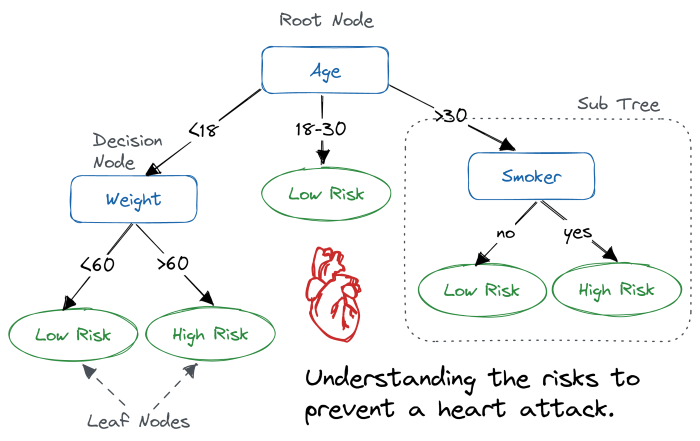

รูปแสดงตัวอย่างโครงสร้างของ decision tree เพื่อประเมินความเสี่ยงในการเกิดโรคหัวใจ [ที่มา](https://images.datacamp.com/image/upload/v1677504957/decision_tree_for_heart_attack_prevention_2140bd762d.png)

พื้นฐานการทำงานของ decision tree คือ การตั้งคำถามและการหาคำตอบในลักษณะ yes หรือ no  ขอยกตัวอย่างกรณีการประเมินความเสี่ยงในการเกิดโรคหัวใจ  ปัจจัยที่มีผลต่อการเกิดโรคหัวใจมีได้หลากหลาย โดยเบื้องต้นอาจจะเป็น อายุ (age) น้ำหนัก (weight) และ การสูบบุหรี่ (smoker) จากปัจจัยทั้งสาม อายุเป็นปัจจัยแรกในการประเมินความเสี่ยง โดยในช่วงอายุ 18-30 ปี จัดเป็นกลุ่มที่มีความเสี่ยงน้อย ในกลุ่มคนที่มีอายุน้อยกว่า 18 ปี จะมีความเสี่ยงสูงที่จะเป็นโรคหัวใจ เมื่อน้ำหนักสูงกว่า 60 กก. จากความอ้วน  ในขณะที่กลุ่มคนที่มีอายุมากกว่า 30 ปี จะมีความเสี่ยงสูงที่จะเป็นโรคหัวใจ เมื่อเป็นผู้สูบบุหรี่  ดังนั้น เมื่อมีการตั้งคำถามและเงื่อนไขเหล่านี้ จะช่วยให้สามารถคัดกรองกลุ่มคนจากระดับความเสี่ยงในการเกิดโรคหัวใจออกเป็น กลุ่มผู้มีความเสี่ยงสูง (high risk) และ กลุ่มผู้มีความเสี่ยงต่ำ (low risk) อันจะมีประโยชน์ในการวางแผนป้องกันโรคหัวใจต่อไป

ทั้งนี้ เพื่อให้ decision tree ถูกประมวณผลโดยคอมพิวเตอร์ คำถามและเงื่อนไขเหล่านี้จะมีรูปแบบเป็นเงื่อนไขเชิงตรรกะในลักษณะ  $x < x_0$ เมื่อ $x$ คือ feature ของชุดข้อมูล  และ $x_0$ คือ ค่าเกณฑ์เงื่อนไขในการตัดสินใจ  เริ่มต้นจากเงื่อนไขแรก ชุดข้อมูลจะถูกแบ่งเป็นกลุ่มย่อยๆ เพื่อเข้าสู่เงื่อนไขต่อไป กระบวนการเช่นนี้จะเกิดขึ้นซ้ำไปเรื่อยๆ และข้อมูลจะถูกแบ่งเป็นกลุ่มเล็กลงเรื่อยๆ จนกระทั่งสามารถแยกคลาสออกจากกันได้ในที่สุด

โครงสร้างของ decision tree จึงคล้ายกับต้นไม้ที่มีลำต้น (**root node**) และแตกกิ่งก้าน (**branch** หรือ **sub-tree**) ตามเงื่อนไขที่ตั้งขึ้น  โดยกล่องเงื่อนไขเหล่านี้ มีชื่อเรียกเฉพาะว่า **decision node** และกล่องปลายกิ่งที่มีข้อมูลของกลุ่มย่อยสุดท้าย เรียกว่า **leaf node** หรือ **terminal node**

ใน tutorial นี้ เราจะแสดงการทำงานของโมเดลกับโจทย์การจำแนกหมวดหมู่ผ่านการเรียกใช้ [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) ในไลบรารี่ `scikit-learn`

เพื่อศึกษาการทำงานของโมเดล decision tree เราจะลองสร้างชุดข้อมูลที่ประกอบไปด้วยข้อมูลจำนวน $200$ จุด ที่ประกอบด้วย 2 features และ 2 classes ได้แก่ class 0 และ class 1 (2-class dataset for binary classification)  โดยข้อมูลในแต่ละคลาสมีจำนวนเท่ากันที่ 100 จุด

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 2566

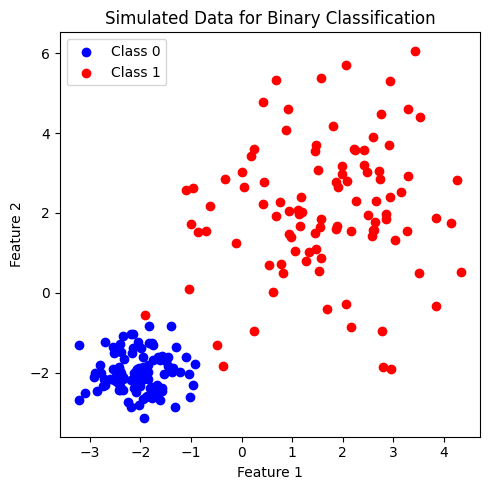

In [2]:
def generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples):
    # สร้างชุดข้อมูลแบบ multi-class
    # ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
    np.random.seed(RANDOM_SEED)

    # กำหนด จำนวน features
    n_features = 2

    #  สร้างข้อมูล x สำหรับแต่ละคลาส
    x_data = []
    for label in range(n_classes):
        _ = np.random.normal(mean_class[label], std_class[label], (n_samples, n_features))
        x_data.append(_)

    # สร้างข้อมูล y หรือ labels สำหรับแต่ละคลาส
    y_data = []
    y_data.append(np.zeros(n_samples))
    for label in range(1, n_classes):
        y_data.append(label*np.ones(n_samples))

    # รวมข้อมูล x และ y จากทุกคลาส
    x = np.vstack((x_data))
    y = np.hstack(y_data)

    return x, y

# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [2,2]]
std_class  = [[0.5,0.5], [1.5,1.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

ข้อมูลที่สร้างขึ้นมีการแบ่งกลุ่มค่อนข้างชัดเจน  โดยเป็นข้อมูลชุดเดียวกันกับที่เราใช้ศึกษาการทำงานของโมเดล logistic และ โมเดล SVM ใน tutorial ก่อนหน้า  โดยพบว่า โมเดล logistic ได้เลือก linear decision boundary เป็นเส้นตรงที่สามารถจำแนกคลาสได้ดีที่สุด  ในขณะที่โมเดล SVM จำแนกชุดข้อมูลนี้ด้วย decision boundary ที่มีลักษณะได้ทั้ง linear หรือ non-linear ตาม kernel ที่เลือกใช้

เราจะให้โมเดล decision tree เรียนรู้ข้อมูลชุดนี้ โดยใช้ default hyperparameters นั่นคือ โมเดลสามารถแต่กิ่งไปได้เรื่อยๆ เพื่อลดการปะปนกันของคลาส (imputity) จนได้ข้อมูลกลุ่มย่อยสุดท้ายที่มีคลาสเดียวกัน  ซึ่งกระบวนการนี้ในเชิงเทคนิค คือ การพยายามลดค่า Gini imputity ให้ต่ำที่สุดจนกลายเป็น 0

ทั้งนี้ สามารถศึกษา Gini impurity และ classification criteria อื่นๆ ได้เพิ่มเติมจาก
[classification criteria](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)



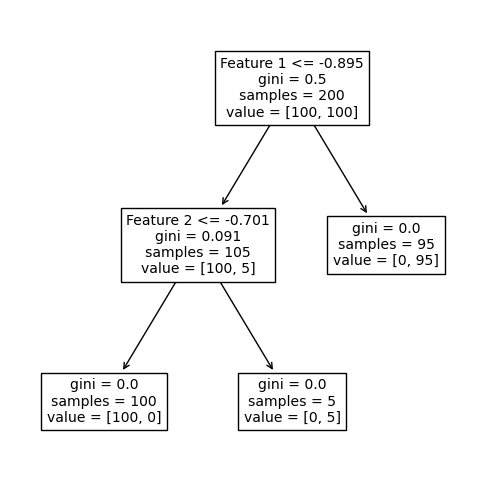

In [3]:
# สร้างชุดโมเดล
clf = DTC(random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot Decision Tree
plt.figure(figsize = (5,5))
tree.plot_tree(clf, feature_names=['Feature 1','Feature 2'])
plt.tight_layout()
plt.show()

พบว่า ต้นไม้มีการตัดสินใจด้วย 2 เงื่อนไข คือ
1. Feature 1 มีค่าน้อยกว่า -0.895
2. Feature 2 มีค่าน้อยกว่า -0.701

โดยเมื่อพิจารณาข้อมูลกลุ่มย่อยที่ปลายกิ่ง พบว่า ค่า impurity (gini) เป็นศูนย์ และ กลุ่มข้อมูลย่อย (samples) อยู่ในคลาสเดียวกัน (ค่า value ไม่เป็นศูนย์ที่คลาสใดคลาสหนึ่ง)

ต่อไปเราจะแสดง decision boundary ของโมเดล decision tree

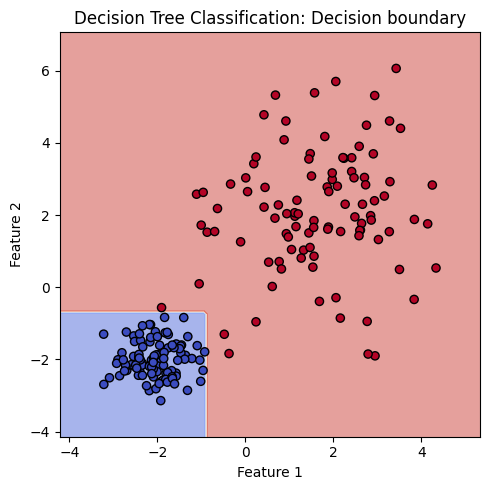

In [4]:
# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Decision Tree Classification: Decision boundary')
plt.tight_layout()
plt.show()

ภาพแสดง decision boundary ที่มีลักษณะเป็นกล่อง  ซึ่งเกิดจากการคัดกรองข้อมูลตามเงื่อนไขในการตัดสินใจ 2 เงื่อนไขที่แสดงก่อนหน้านี้  ซึ่งแตกต่างจาก decision boundary ของโมเดล logistic และโมเดล SVM ที่พบก่อนหน้านี้อย่างชัดเจน

ต่อไปเราจะลองสร้างข้อมูลที่จำแนกคลาสได้ยากขึ้น โดยให้ข้อมูล 2 คลาสกระจายตัวปะปนกัน  เพื่อดูโครงสร้างต้นไม้และ decision boundary

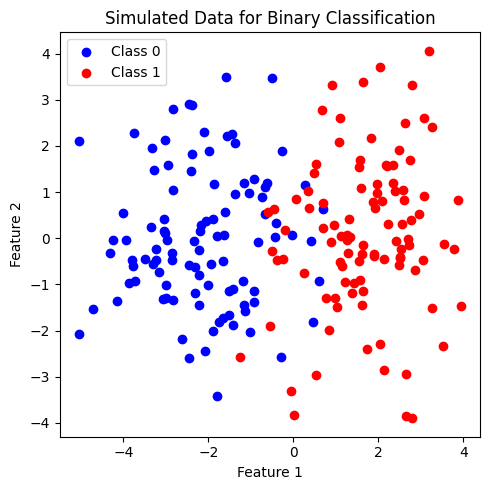

In [21]:
# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-0], [2,0]]
std_class  = [[1.25,1.5], [1.25,1.5]]
#mean_class = [[-2,-1], [2,0]]
#std_class  = [[1,1.5], [1,1.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

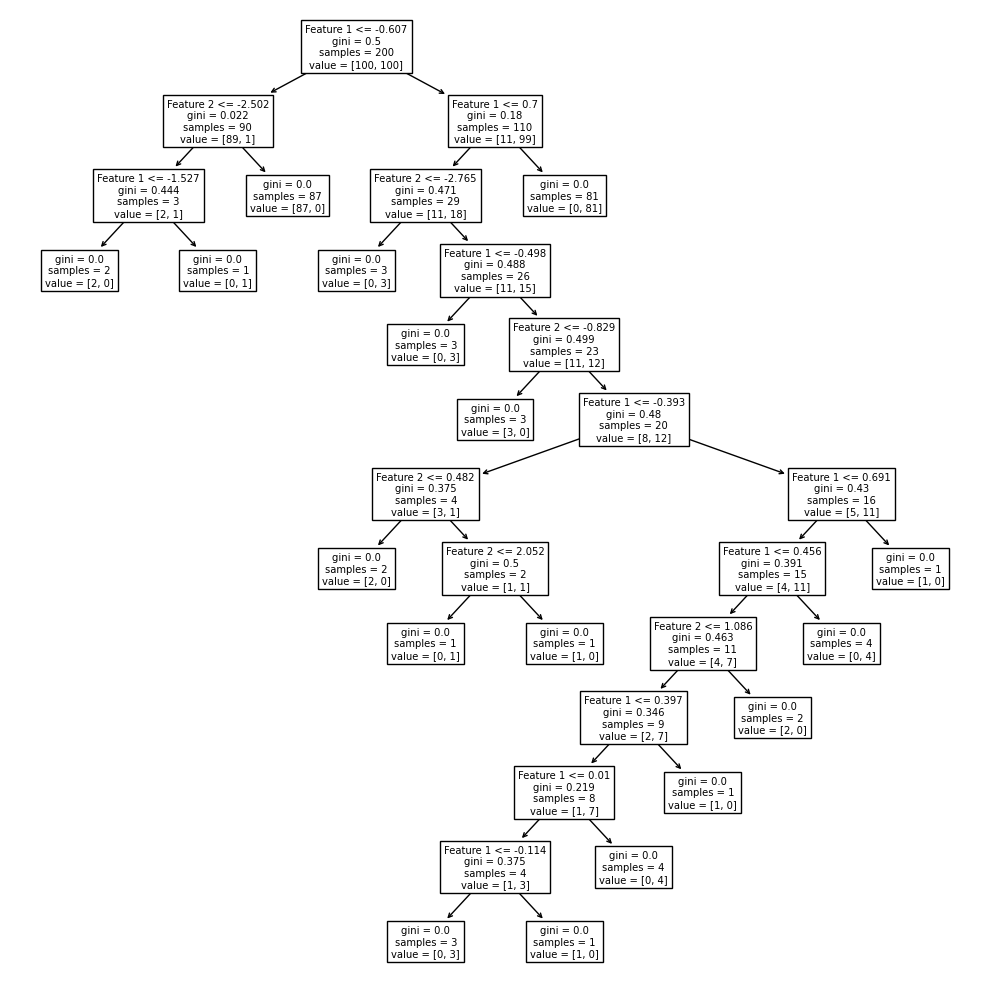

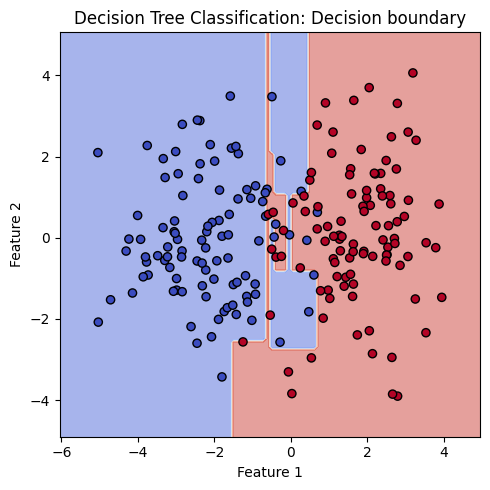

In [6]:
# สร้างชุดโมเดล
clf = DTC(random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot Decision Tree, showing decision path
plt.figure(figsize = (10,10))
tree.plot_tree(clf, feature_names=['Feature 1','Feature 2'])
plt.tight_layout()
plt.show()

# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Decision Tree Classification: Decision boundary')
plt.tight_layout()
plt.show()

เมื่อให้โมเดล decision tree เรียนรู้จากข้อมูลที่มีความซับซ้อน  โมเดลจะสร้างเงื่อนไขจำนวนมากเกิดเป็นต้นไม้ที่มีขนาดใหญ่ เพื่อพยายามจำแนกคลาสให้ได้มากที่สุด  ส่งผลให้โมเดลเกิดปัญหา overfitting (การที่โมเดลเรียนรู้มากเกินไปจนจดจำคำตอบ) ซึ่งสามารถสังเกตได้จาก decision boundary

จะเห็นได้ว่า โมเดล decision tree มีข้อดีที่มีการเรียนรู้ข้อมูลด้วยการสร้างเงื่อนไขตัดสินใจเชิงตรรกะที่เข้าใจได้ง่าย และสามารถอธิบายการทำงานได้ชัดเจนจากโครงสร้างต้นไม้  แต่ในขณะเดียวกัน โมเดลก็มีข้อเสียที่มักเกิด overfitting โดยเฉพาะเมื่อชุดข้อมูลมี noise มาก  ซึ่งสามารถแก้ไขเบื้องต้นโดยการปรับค่า hyperparameters ไม่ให้ต้นไม้แตกกิ่งมากจนเกินไป และการทำ pruning ซึ่งเป็นกระบวนการลดขนาดของต้นไม้  นอกจากนี้ หากเรานำต้นไม้หลายๆ ต้นมาเรียนรู้ข้อมูลแล้วให้ร่วมกันโหวดคำตอบสุดท้าย ก็จัดเป็นอีกหนึ่งวิธีที่สามารถลดปัญหา overfitting ลงได้ โดยหนึ่งในโมเดลที่ต่อยอดจากโมเดล decision tree ในลักษณะนี้ คือ โมเดล random forest ที่จะศึกษาในลำดับถัดไป

ทั้งนี้ โมเดล decision tree พื้นฐานในการพัฒนา machine learning algoriths หลายตัวที่ใช้อย่างแพร่หลายในปัจจุบัน ผ่านกระบวนการ [ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html) ต่างๆ โดยสามารถศึกษาเพิ่มเติมได้


# Random Forest

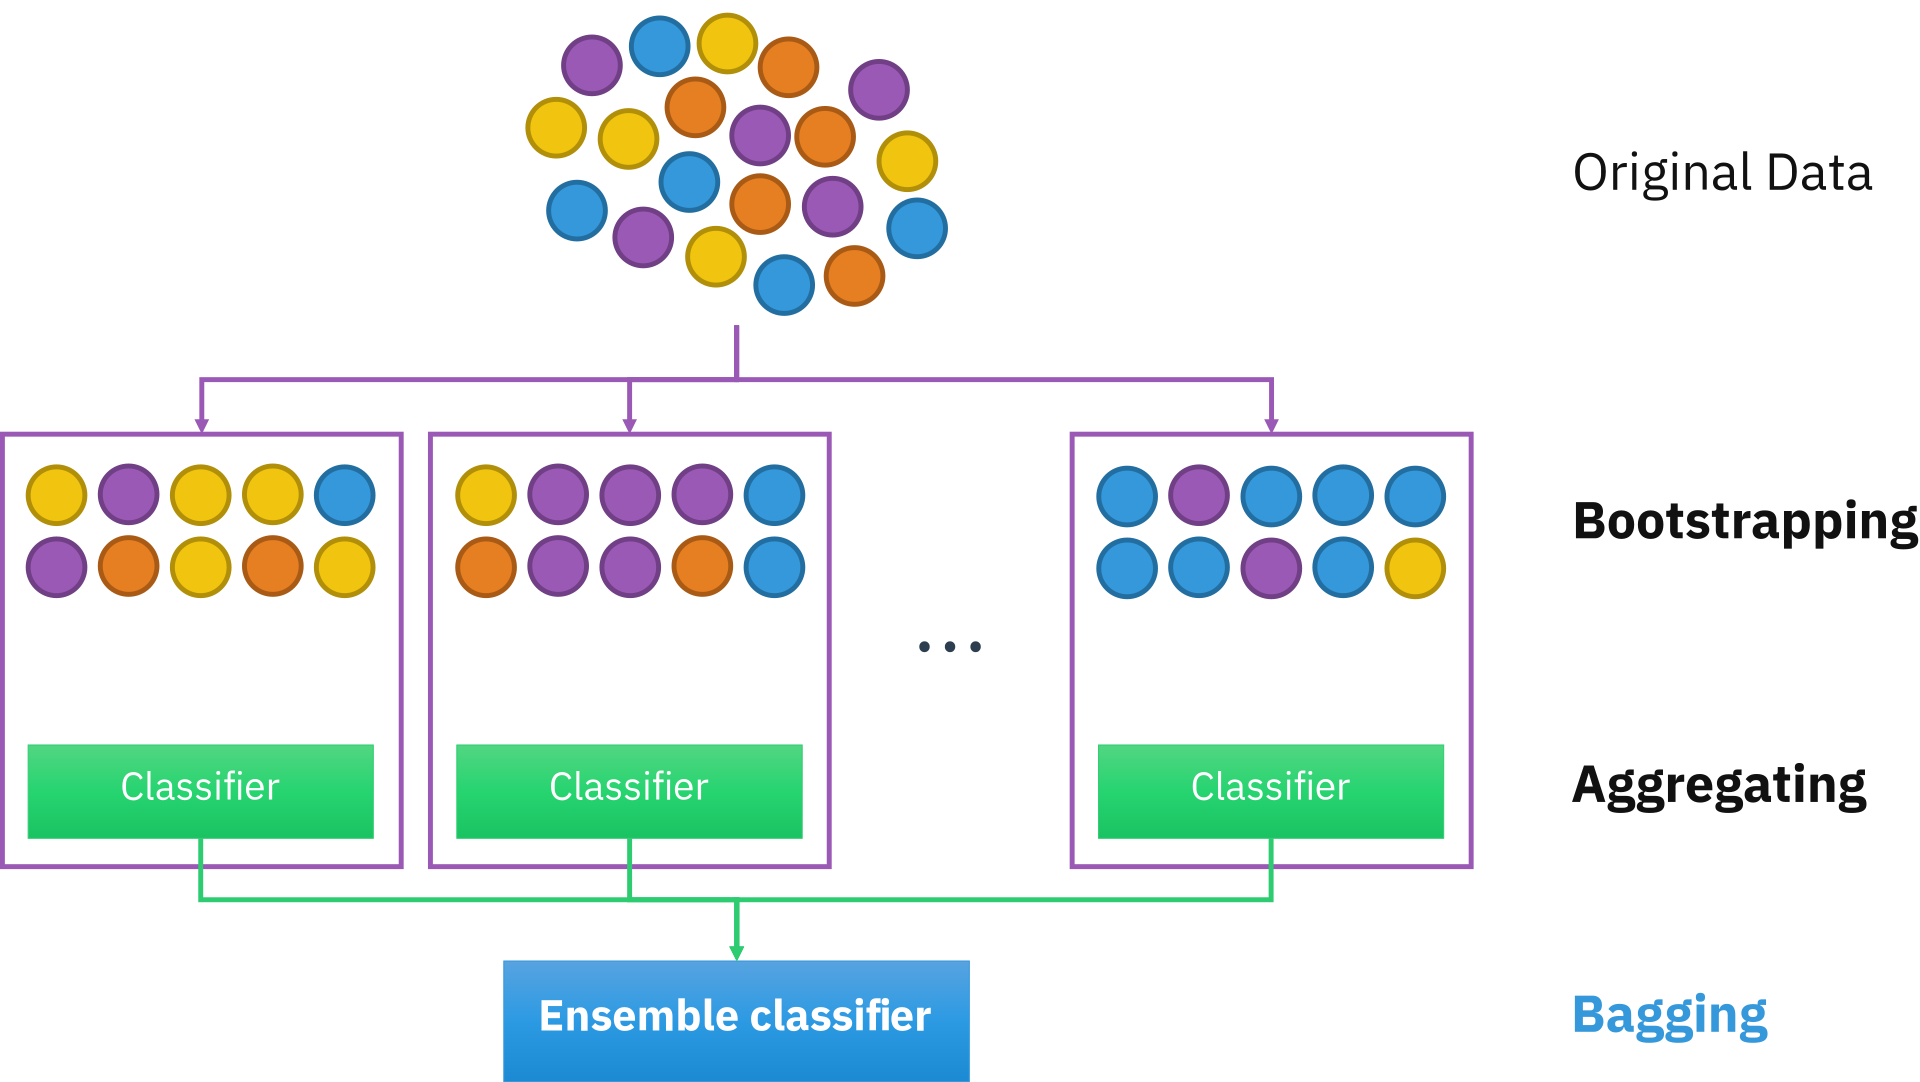

แผนภาพแสดง Ensemble bagging ที่มา: wikipedia.com

**Random forest** เป็นการทำงานร่วมกันของโมเดล decision tree หลายๆ โมเดล โดยประกอบด้วย 2 ขั้นตอนหลัก คือ (i) โมเดล decision tree แต่ละโมเดลแยกกันเรียนรู้จากชุดข้อมูล และ (ii) ทุกโมเดลกลับมาร่วมกันให้คำตอบ

กระบวนการทำงานของ random forest algorithm จึงเริ่มต้นด้วยการสร้างชุดข้อมูลย่อยๆ ตามจำนวนโมเดล decision tree ที่ต้องการพัฒนา โดยใช้วิธีการสุ่มเลือกจุดข้อมูลแบบไม่แยกจุดข้อมูลที่ถูกเลือกออกจากชุดข้อมูลหลัก (เสมือนกับการสุ่มหยิบลูกบอลออกจากกล่อง บันทึกลักษณะ แล้วก็ใส่ลูกบอลคืนลงกล่อง ก่อนที่จะมีการสุ่มหยิบลูกบอลครั้งต่อไป)  ทำให้ข้อมูลแต่ละจุดสามารถถูกเลือกได้หลายครั้งหรืออาจจะไม่ถูกเลือกเลย  วิธีการนี้ทำให้เราได้ชุดข้อมูลจำนวนมากที่แตกต่างกันแต่มีขนาดที่เท่ากัน โดยวิธีการสุ่มเลือกแบบนี้ มีชื่อเรียกเฉพาะว่า **bootstraping** (random sampling with replacement)  ในขณะที่โมเดล decision tree เรียนรู้จากชุดข้อมูลที่ได้รับ จะมีการสุ่มเลือก features จำนวนหนึ่งให้โมเดลเลือกใช้ในการสร้างเงื่อนไขแตกกิ่งในแต่ละครั้ง เพื่อให้แต่ละโมเดลตั้งเงื่อนไขที่มีความหลากหลาย  หลังจากนั้น เราจะให้โมเดลมาร่วมโหวดคำตอบสุดท้ายร่วมกัน

กระบวนการทั้งหมดนี้ เป็น ensemble method ที่เรียกว่า **bagging** หรือ **bootstrap aggregating**  การทำ bagging ช่วยลดความผิดพลาดในการทำนายจาก overfitting โดยใช้ประโยชน์จากการเพิ่มความหลากหลายของ training data และโมเดลที่สร้างขึ้น

โมเดล Random Forest สามารถนำไปใช้งานได้ทั้งการจำแนกหมวดหมู่ (classification) และการทำนายค่า (regression)  โดยใน tutorial นี้ เราจะแสดงการทำงานของโมเดลกับโจทย์การจำแนกหมวดหมู่ผ่านการเรียกใช้ [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) ในไลบรารี่ `scikit-learn`

## Random Forest เมื่อปรับค่า `'n_estimators'` (จำนวนต้นไม่้)

จากชุดข้อมูลที่สร้างขึ้นก่อนหน้านี้ เราจะมาดูผลของการปรับค่า `'n_estimators'` ต่อความแม่นยำของโมเดลและระยะเวลาที่ต้องใช้ในการพัฒนาโมเดล

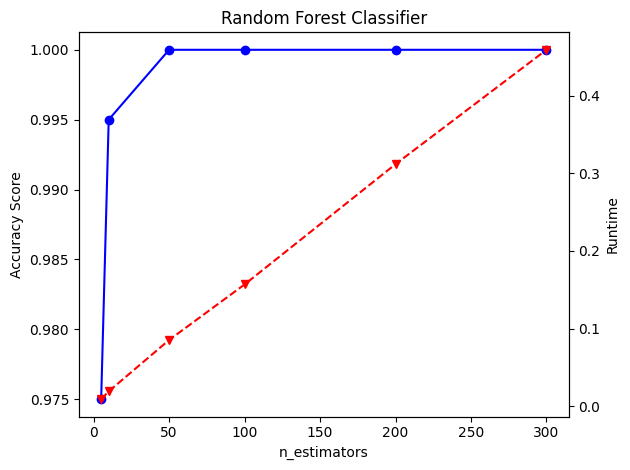

In [19]:
import time

# กำหนดช่วงค่าต้นไม้ หรือ n_estimators
n_estimators = [5,10,50,100,200,300]

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
accuracy = []
runtimes = []
for n in n_estimators:
    start_time = time.time()  # เริ่มจับเวลา

    # สร้างชุดโมเดล
    clf = RFC(n_estimators=n, random_state=RANDOM_SEED)

    # สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
    clf.fit(x, y)

    runtimes.append((time.time() - start_time)) # หยุดจับเวลา

    # ทำนายค่า y โดยใช้โมเดล
    prediction = clf.predict(x)

    # คำนวณ accuracy score
    accuracy.append(accuracy_score(y, prediction))

# แสดงผล
fig, ax1 = plt.subplots()
ax1.plot(n_estimators, accuracy, 'bo-')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Accuracy Score')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(n_estimators, runtimes, 'rv--')
#plt.yscale('log')
ax2.set_ylabel('Runtime')

plt.title('Random Forest Classifier')
plt.tight_layout()
plt.show()

การเพิ่มค่า `'n_estimators'` หรือจำนวนต้นไม้ ส่งผลให้เพิ่มระยะเวลาการคำนวณอย่างมีนัยยะสำคัญ  ดังนั้น เราจึงควรเลือกค่า `'n_estimators'` ที่ให้ accuracy สูง โดยไม่ใช้เวลาในการพัฒนาโมเดลมากจนเกินไป จากรูปด้านบน เราสามารถเลือกค่า `'n_estimators' = 50` ก็เพียงพอ

Number of Decision Trees: 50


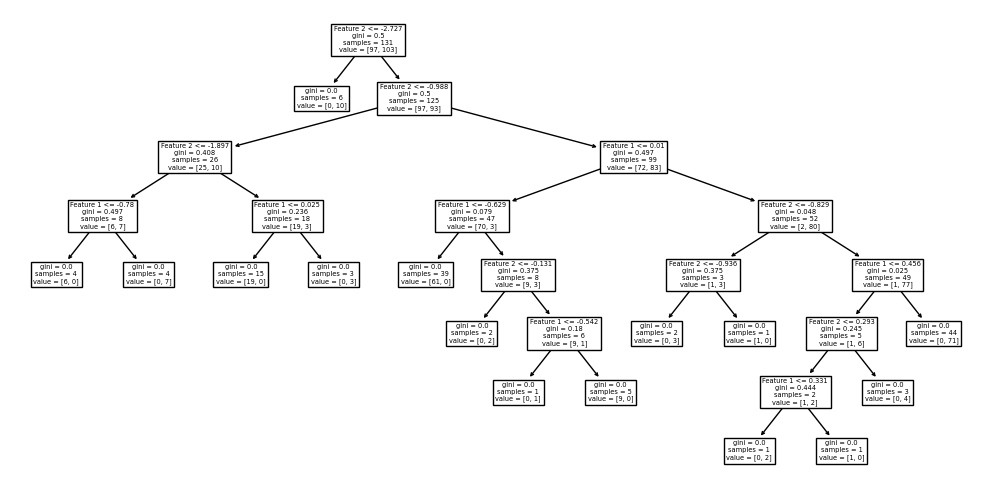

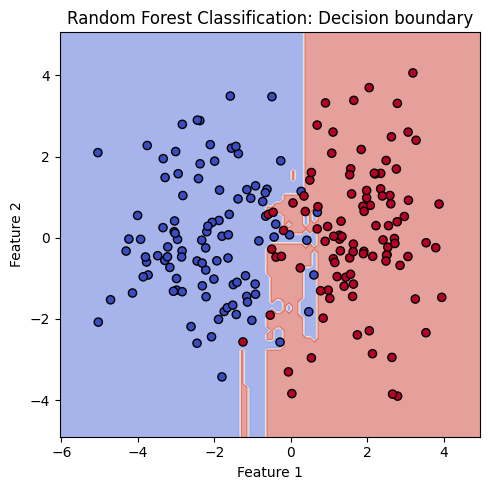

In [8]:
# สร้างชุดโมเดล
clf = RFC(random_state=RANDOM_SEED, n_estimators=50)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# แสดงจำนวนต้นไม้
print('Number of Decision Trees:',clf.n_estimators)

# Plot Decision Tree แสดง decision path ของต้นไม้ 1 ต้นแรก
for i in range(1):
    #tree_i = clf.estimators_[i]
    plt.figure(figsize = (10,5))
    tree.plot_tree(clf.estimators_[i],feature_names=['Feature 1','Feature 2'])
plt.tight_layout()
plt.show()

# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Random Forest Classification: Decision boundary')
plt.tight_layout()
plt.show()

จะสังเกตได้ว่า decision boundary ยังมีลักษณะค่อนข้าง overfitting นั่นเป็นเพราะโมเดลมี default criteria ให้แตกกิ่งต้นไม้จนกว่า Gini impurity เป็น 0 ต้นไม้จึงมีขนาดใหญ่โดย terminal node มีจำนวนข้อมูลน้อยมาก เช่น desicion node ล่างสุดที่โมเดลสร้างเงื่อนไขขึ้นเพียงเพื่อจำแนก 2 จุดข้อมูลออกจากกัน  ซึ่งเราสามารถควบคุมขนาดต้นไม้ได้ด้วยการควบคุม hyperparameters เช่น `'max_depth'`, `'min_samples_split'`, `'min_samples_leaf'` เป็นต้น ซึ่งสามารถศึกษาความหมายเพิ่มเติมได้จากเวปไซส์ของ `scikit-learn` [link](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

โดยในที่นี้เราจะลองควบคุมขนาดต้นไม้ด้วยค่า `'max_depth'` ต่อไป

## Random Forest เมื่อปรับค่า `'max_depths'` (ความใหญ่ของต้นไม้)

ค่า default ของ `'max_depth' = None` ซึ่งหมายความว่า ต้นไม้จะสร้างเงื่อนไขแตกกิ่งไปจนกว่าข้อมูลในกลุ่มย่อยเป็นคลาสเดียวกันทั้งหมด ซึ้งทำให้ต้นไม้มีขนาดใหญ่และเกิด overfitting ได้ง่าย  โดยเราสามารถกำหนดจำนวนชั้นของ decision node ได้ด้วยการปรับค่า `'max_depths'` ด้วยจำนวนเต็มบวก

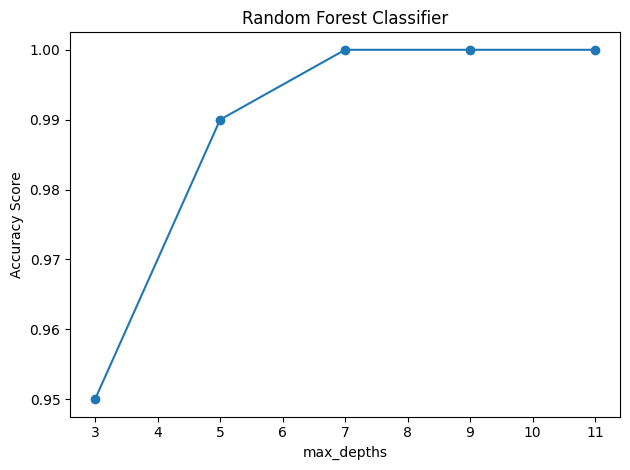

In [22]:
# กำหนดจำนวนต้นไม้ หรือ n_estimators
n_estimator = 50

# กำหนดความลึก (จำนวนชั้นกิ่ง) สูงสุดของต้นไม้
max_depths = [3,5,7,9,11]

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
accuracy = []
for n in max_depths:
    clf = RFC(n_estimators=n_estimator, max_depth=n, random_state=RANDOM_SEED)
    clf.fit(x, y)

    # ทำนายค่า y โดยใช้โมเดล
    prediction = clf.predict(x)

    # คำนวณ accuracy score
    accuracy.append(accuracy_score(y, prediction))

# แสดงผล
plt.plot(max_depths, accuracy, marker='o')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('max_depths')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Classifier')
plt.tight_layout()
plt.show()

เมื่อ `'max_depths'` มีค่าสูงขึ้น ความแม่นยำของโมเดลจะสูงขึ้นด้วย โดยในการสร้างโมเดลนี้ ค่า accuracy เปลี่ยนแปลงน้อยมากเมื่อ `'max_depths' ≥ 7`

**Quiz**: ถ้าลด `max_depths` มากเกินไป จะเป็นอย่างไร

ต่อไปเราจะลองปรับค่า `n_estimators` และ `max_depth` ควบคู่กันไป เพื่อดูผลของ boundary decision

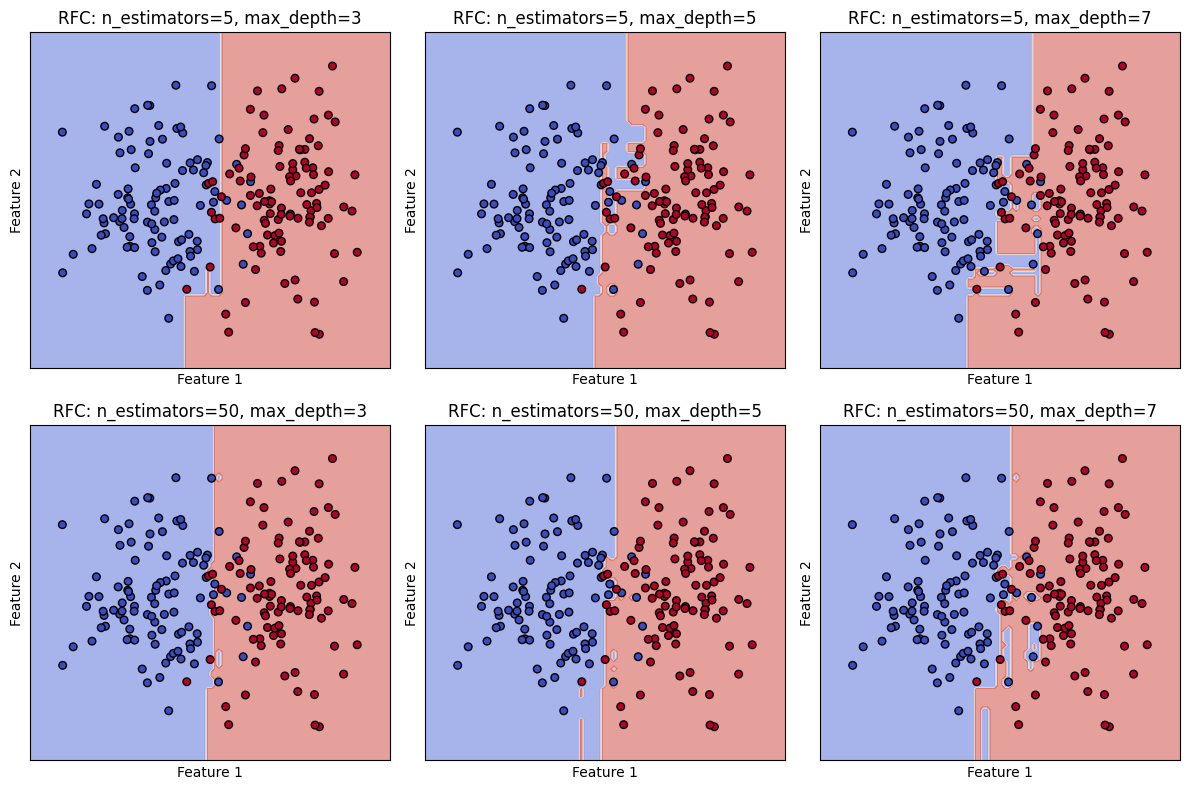

In [24]:
# สร้างชุดโมเดล
models = (RFC(n_estimators=5, max_depth=3),
          RFC(n_estimators=5, max_depth=5),
          RFC(n_estimators=5, max_depth=7),
          RFC(n_estimators=50, max_depth=3),
          RFC(n_estimators=50, max_depth=5),
          RFC(n_estimators=50, max_depth=7),
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['RFC: n_estimators=5, max_depth=3',
          'RFC: n_estimators=5, max_depth=5',
          'RFC: n_estimators=5, max_depth=7',
          'RFC: n_estimators=50, max_depth=3',
          'RFC: n_estimators=50, max_depth=5',
          'RFC: n_estimators=50, max_depth=7',
          ]

# plot the decision boundaries
fig, axes = plt.subplots(2,3, figsize=(4*3, 4*2))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

จะเห็นได้ว่า ในขณะที่การใช้ค่า `'n_estimators'` สูงสามารถช่วยลดการเกิด overfitting แต่การใช้ค่า `'max_depths'` ที่สูงเกินไปจะทำให้เกิด overfitting

เพิ่อลดปัญหา overfitting การปรับค่า `'n_estimators'` และ `'max_depths'` ควบคู่กันไปจึงมีความสำคัญมาก

**Discuss**: สำหรับข้อมูลชุดนี้ เราควรเลือก `N_estimators` และ `max_depths` ให้มีค่าเท่าไหร่

## Random Forest Classification Pipeline

ต่อไปเราจะลองพัฒนาโมเดล random forest อย่างครบกระบวนการ ด้วยชุดข้อมูลที่จะสร้างขึ้น

### Generate 3-class Dataset

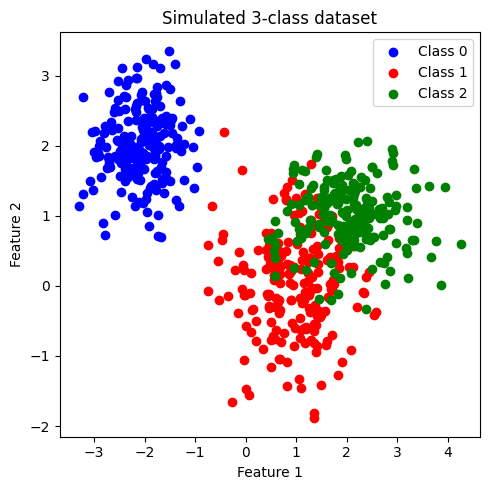

In [11]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [1,0], [2,1]]
std_class  = [[0.5,0.5], [0.75,0.75],[0.75,0.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 200

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()


ข้อมูลที่สร้างขึ้นมีประกอบด้วย 2 features และ 3 classes (class: 0, 1, 2) โดยข้อมูลในแต่ละคลาสมีจำนวนเท่ากันที่ 200 จุด   เราจะพัฒนาโมเดล random forest เพื่อจำแนกข้อมูลแต่ละคลาสออกจากกัน

เมื่อสังเกตการกระจายตัวของข้อมูล พบว่า class 0 มีการกระจายข้อมูลแบ่งแยกออกมาอย่างเห็นได้ชัด ในขณะที่ class 1 และ class 2 จะกระจายตัวอยู่ร่วมกัน

### แบ่งข้อมูลเป็น training data และ test data

โดยใช้ [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) จากไลบรารี่ `scikit-learn`

ในตัวอย่างนี้เราจะใช้ default value ซึ่งจะ shuffle ข้อมูลก่อนแบ่งข้อมูล และ ไม่ stratify (ไม่กำกับสัดส่วนของคลาสใน training data และ test data)

อย่างไรก็ดี ในกรณีที่ข้อมูลประกอบด้วยคลาสต่างๆ ที่มีสัดส่วนต่างกันอย่างมาก (imbalanced dataset) การทำ stratify มีความจำเป็นอย่างมากเพื่อคงสัดส่วนของแต่ละคลาส ใน training data และ test data

In [12]:
# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=None,
                                                    shuffle=True,
                                                    random_state=RANDOM_SEED)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[  0. 169.]
 [  1. 155.]
 [  2. 156.]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 31.]
 [ 1. 45.]
 [ 2. 44.]]


### ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ standard deviation (SD) จาก training data ในการ standardize test set เพื่อป้องกัน information leak

In [13]:
# สร้าง standardized scaler จาก features ใน training data
x_scaler = StandardScaler().fit(x_train)

# scale ค่า features ใน training data และ test data
x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)

### เทรนโมเดล ด้วย base model (default hyperparameter)

Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       169
         1.0       1.00      1.00      1.00       155
         2.0       1.00      1.00      1.00       156

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.80      0.91      0.85        45
         2.0       0.89      0.77      0.83        44

    accuracy                           0.88       120
   macro avg       0.90      0.89      0.89       120
weighted avg       0.89      0.88      0.88       120



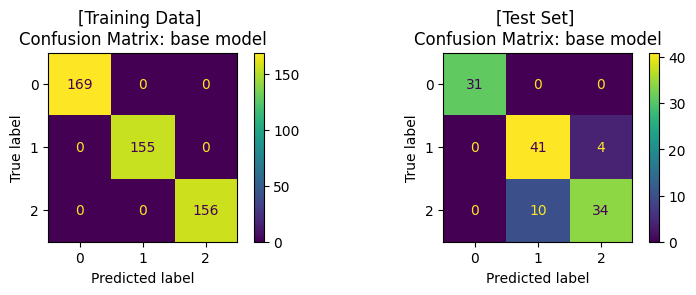

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# สร้างโมเดล
base_clf = RFC(random_state=RANDOM_SEED)

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: base model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: base model')

plt.tight_layout()
plt.show()

### ปรับแต่งโมเดล (Hyperparameter Tuning) ด้วย [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) และ train โมเดล

โดยเราจะปรับแต่งโมเดล โดย tune 2 hyperparameters ที่สำคัญของ logistic regression ได้แก่
1. `'n_estimators'`
2. `'max_depth'`

ในไลบรารี่ `scikit-learn` ยังมีวิธีการอื่นๆ ในการปรับแต่งโมเดล เช่น
- [CrossValScore](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)



Best hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Best cross-validation score: 0.90
Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       169
         1.0       0.91      0.81      0.86       155
         2.0       0.83      0.92      0.87       156

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.92      0.91      0.91       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.93      0.84      0.88        45
         2.0       0.85      0.93      0.89        44

    accuracy                           0.92       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.92      0.92      0.92       120



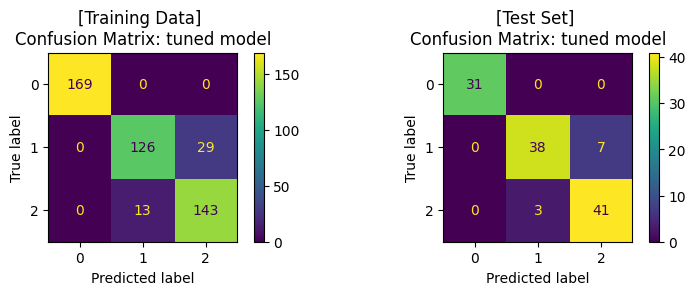

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
clf_params = {'n_estimators': [10,50,100,200],
              'max_depth': [3, 5]
              }
# แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params
# และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
# โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                             scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

# fit โมเดลด้วย training data และ ให้โมเดลทำนายค่า y จาก training data
tuned_clf.fit(x_train, y_train)
y_pred = tuned_clf.predict(x_train)

# แสดงผล hyperparameters ที่ดีที่สุด และ cross-validation score
print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของโมเดลจาก training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')

# ให้โมเดลทำนายค่า y จาก test data
y_pred = tuned_clf.predict(x_test)

# แสดงผล classification ของโมเดล จาก test data
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))
# คำนวนและแสดงผล confusion matrix จาก test data
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

plt.tight_layout()
plt.show()

จะสังเกตได้ว่า เมื่อมีการปรับจูน hyperparameters ของโมเดลให้มีความเหมาะสมแล้ว เราได้โมเดลที่เรียนรู้จากข้อมูลชุดเดิม แล้วสามารถทำนายได้ค่า accuracy ที่สูงขึ้น โดยเมื่อพิจารณา Confusion Matrix จะพบว่า โมเดลสามารถจำแนกข้อมูล class 1 และ class 2 ได้ดีขึ้น

### Impurity-based Feature Importances

โมเดล random forest สามารถคำนวณค่า relative feature importance ของแต่ละ feature ได้  บนหลักการที่ว่า feature ที่สำคัญ คือ feature ที่ช่วยจำแนกคลาสได้ดี หรือ ลดการปะปนของคลาสในข้อมูลได้มาก (ลด impurity) โดยผลรวมของ relative feature importance จะเท่ากับ 1

In [16]:
# หาค่า feature importances
importances = clf.feature_importances_

# แสดงค่า feature importances
print('Relative Feature Importances:')
print('Feature 1: {:.2f}'.format(importances[0]))
print('Feature 2: {:.2f}'.format(importances[1]))

Relative Feature Importances:
Feature 1: 0.87
Feature 2: 0.13


Feature 1 ค่อนข้างมีความสำคัญอย่างมากในการจำแนกคลาส เมื่อเทียบกับ Feature 2  สอดคล้องกับ scatter plot แสดงการกระจายตัวของชุดข้อมูลบน feature space